# Code Availability
This code is written in Python (3.6>) and publicly available. The aim is to provide a custom code to process, visualize and manipulate the SandBoxNL dataset. This statement is included under the heading "Code availability" of the publication: "Sentinel-1 SAR based parcel level crop data in The Netherlands". [Vineet Kumar, Manuel Huber, Bjorn Rommen, and Susan C. Steele-Dunne]

Support:
In the case of any issues or inquiries please contact either:

Vineet Kumar (TU Delft, V.Kumar-1@tudelft.nl), 
Manuel Huber (ESA, ESTEC, manuel.huber@esa.int), 
Susan Steele-Dunne (TU Delft, s.c.steele-dunne@tudelft.nl), 
Björn Rommen (ESA, ESTEC, Bjorn.Rommen@esa.int)

# Introduction: SandBoxNL Dataset - Coherence
The annual database consists of spatially averaged VV coherence data and corresponding standard deviation for each parcel. Every crop parcel has a unique field ID (OBJECTID), which is used as an index to sort, process and clean the data. Each parcel is stored separately in a data frame containing the time series of all the above-mentioned extracted parameters. The dataset are provided per province and annually.

The following code gives a brief example of how to access, manipulate and visualize the pickle dataset with Flevoland (2019), Orbit 88.

In [6]:
"""
 -*- coding: utf-8 -*-
Created on Tue Apr  6 16:05:00 2021
@author: Manuel Huber (ESA, ESTEC: manuel.huber@esa.int)
"""

import netCDF4 as nc4
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
import pickle
from datetime import datetime, date, time
import glob
import math    
import os
import pickle5 as pickle
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [7]:
# Reading the data.... 
# Example for one slice of orbit 88 in 2019
'
year = 2019
# Path of netCDF datasets (per province)
path_save ='C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/Coherence Datasets/Coh_VV_88_{}/'.format(year)

# Selecting one province as example... 

infile = open('{}Dict_Coherence_88_VV_{}.pickle'.format(path_save,year),'rb')
coh88 = pickle.load(infile)


# Selecting and loading PDOK shp files for geometry and crop description...
fields = gpd.read_file('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/SandBoxNL/SandboxNL/April_2020/BRP_2019_proj/BRP_Proj_2019.shp') 

# Find crop types from BRP parcel name list.
The Basisregestratie GewasPercelen (BRP, Base Crop Parcel Register) shape filescontains parcel name information in Dutch. To extract the information about theparticular parcel or crop type user needs to input/query the database in Dutch. Hence to assist crop type information, we have provided the following list detailsthe corresponding crop name in English  ("BRP_Parcel_Name_list_dutsch_english_2019") . 

User needs to input exact name of crop in Dutch language including the special characters (Example: Aardappelen, bestrijdingsmaatregel AM). These following list is created by using BRP 2019 data. Specifically Maize crop has a special character in the BRP-2019 shape files,(Ma�s, snij-). So, user should carefully input while calling 2019 maize cropdatabase. For 2017 and 2018 Maize crop can be called with actual Dutchword (Maïs) for it.

The following code should help to select the correct dutch crop names. Two functions are implemented to either find the corresponding names using either a english crop name or starting letter. In total 312 different crops are prese

In [ ]:
# Loading the excel sheet, which contains the dutch and english description of the crop types
translate = pd.read_excel('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/Translation_List_Dutch_English_Crop_Names_2019.xlsx')
translate.index = translate['Crop_Number'].astype(int)  # The crop number refers to the 'GWS_GEWASC' number of the BRP/Fields files
del translate['Crop_Number']

# Function to find all descriptive names (dutch and englisch) for a given crop name/type (given in englisch)
def find_crop_names_per_name(mystring):
    index = []
    for i in range(len(translate)):
        cell = translate['Crop name (English)'].iloc[i]
        if mystring in cell:
            index.append(i)
    return translate.iloc[index]

# Function to find crops with starting letter of the crop name/type (serach in english)
def find_crop_names_per_letter(myletter):
    index = []
    for i in range(len(translate)):
        cell = translate['Crop name (English)'].iloc[i]
        if myletter in cell[0]:
            index.append(i)
    return translate.iloc[index]

# Two examples on how to use the above functions:
example1 = find_crop_names_per_name("Potatoes") # Input must be in english. Sometimes 
                                                # Crops are given in plural or small/big captial starting letter
                                                # If this does not help please search manually in the trasnlation list
print('Output for search using an english name:','\n',example1)


# If it is not possible to find the crop using the full name try to search for the starting letter:
example2 = find_crop_names_per_letter("W") # Input must be in in engish and capital (sometimes large or small)
print('Output for search using a letter:','\n',example2)


# Selecting ObjectIDs and field information depending on longitude and latitude

This is necessary for users, who have a list of longitudes and latitudes and want to select the fields according to those. This can be done using the fields polygons (provided by PDOK). The polygons are selected on the bases that the lon-lat combination (point) is within the outlined polygon. This means that the points must be in the boundary of the parcel in order to be identified. Again, it is to mention that the field locations change per year, which makes it important to always select the correct shapefile. Furthermore, it is important to have loaded the correct netCDF file to match the objectIDs.  

In the following example, points where selected in the Flevoland province.


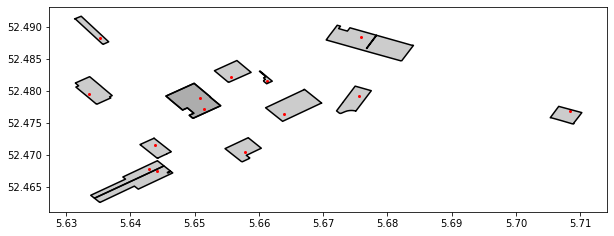

In [8]:
# List of points (this can be integrated by uploading a csv file - in case a lat-lon list exists already)
list_lon_lat = [
    [5.675902485185551,52.48838138537458],
    [5.663843273454594,52.47630669355332],
    [5.655646442705082,52.482083095990625],
    [5.70838940077393,52.476829476115576],
    [5.675602077775883,52.47918192078341],
    [5.651483654313969,52.47722155896118],
    [5.657878040605473,52.470477247257],
    [5.643801807695317,52.47157522890128],
    [5.661268352800297,52.48156037584885],
    [5.650754093461918,52.47884213099183],
    [5.635304569536137,52.48827685681074],
    [5.633502125078129,52.47949557056959],
    [5.642943500810551,52.467889039283634],
    [5.644059299760746,52.46754916228505]
    ]
# Create a geocoded points
df_points = [Point(list_lon_lat[i][0], list_lon_lat[i][1]) for i in range(len(list_lon_lat))]

# Function to extract the polygon for each field in the list
def get_id_per_lon_lat(list_lon_lat, fields):
    ls_points = []
    for i in range(len(list_lon_lat)):                   
        point = Point(list_lon_lat[i][0], list_lon_lat[i][1])
        ls_points.append(fields[fields.geometry.contains(point)])
    return pd.concat(ls_points)

lst_polygons = get_id_per_lon_lat(list_lon_lat, fields) # Apply function *fields = PDOK shapefile
selected_poly  = lst_polygons[lst_polygons.OBJECTID.isin(fh['Parcel_ID']['ID'][:].data)] # Check if the selected fields are in the netCDF dataset
# Plotting the selected parcels for the given points
fig,ax= plt.subplots(figsize=(10,4))
gpd.GeoDataFrame(selected_poly, geometry='geometry').plot(ax =ax, color='grey', alpha = 0.4,  missing_kwds={"edgecolor": "red"}) # Corresponding polygons
gpd.GeoDataFrame(selected_poly, geometry='geometry').boundary.plot(ax =ax, markersize=2, color='black')
gpd.GeoDataFrame(df_points, geometry=df_points).plot(ax =ax, markersize=4,color= 'red') # Points selected by user

selected_IDs = selected_poly.OBJECTID # This gives a list OBJECTIDs corresponding to the selected fields.

# Structuring the data
The pickle data is structed the following:


coh88['mean'] - Gives the VV (mean) coherence for all parcels and time [Parcel:Time]
coh88['std'] - Gives the VV (standard deviation) coherence for all parcels and time [Parcel:Time]
coh88['count'] - Gives the pixel count for all parcels

Here the dates will be stored seperately in a date time format (extracted from the column names):
dates88 = pd.to_datetime(list(coh88['mean'].columns))

    

In [23]:
# Load static data in a pandas dataframe per field ID:
# For further visualization only mean vv values will be used

print('All Information stored in coh88', coh88.keys())
coh = coh88['mean']
keys_ID = coh88['count'].index


# Select relevant parcel infromation from BRP shapefile

fields_sel = fields[fields.OBJECTID.isin(keys_ID)] # Select only field IDs which are represented in the loaded data

print(coh.head())


All Information stored in coh88 dict_keys(['mean', 'std', 'count'])
         2019-01-06  2019-01-12  2019-01-18  2019-01-24  2019-01-30  \
1526148    0.425704    0.445684    0.455794    0.335038    0.514557   
1526156    0.382452    0.350717    0.493865    0.471367    0.606685   
1526157    0.388164    0.369507    0.403095    0.355258    0.591838   
1526158    0.472767    0.393251    0.463411    0.464715    0.701727   
1526159    0.448203    0.413891    0.463235    0.467951    0.631554   

         2019-02-05  2019-02-11  2019-02-17  2019-02-23  2019-03-01  ...  \
1526148    0.451357    0.484607    0.657863    0.587118    0.500796  ...   
1526156    0.458236    0.551264    0.483975    0.433094    0.575119  ...   
1526157    0.411311    0.516068    0.525664    0.475395    0.538921  ...   
1526158    0.470918    0.485569    0.582787    0.548934    0.589946  ...   
1526159    0.453957    0.533186    0.575835    0.571886    0.538565  ...   

         2019-10-27  2019-11-02  2019-11-08  201

# Plotting time series for an example field

Here the static information can be used to select specific parcels. For example, certain crop types and specific lon and lat etc. 


Text(0.5, 1.0, '1526148 - Orbit 88')

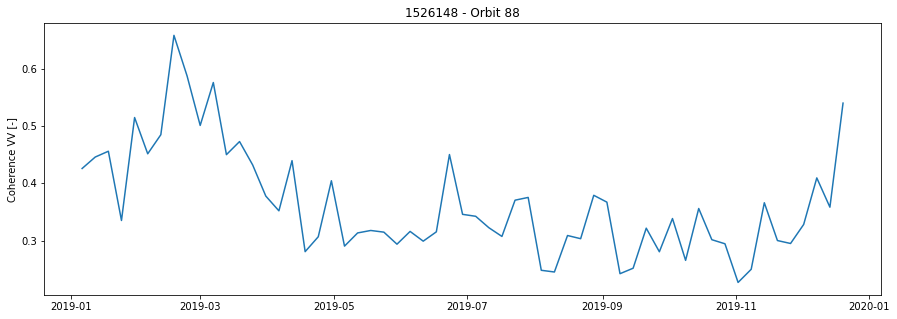

In [15]:
# First Plotting time series.... Comparing backscatter signal from all orbits to one orbit:
'''
Variables: 
 ['vv_mean', 'vv_std', 'vh_mean', 'vh_std', 'OID', 'pix', 'MID', 'RO', 'time_num']
These can be used as a vector or directly as a string.

'''

# Example selection of the first field in the dataframe
field = 0  
# Plotting vv mean backscatter
df_plot = coh.iloc[field] # Or if plotting for specifc Object id coh[coh.index==OBJECTID]
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(dates88, df_plot.values)
plt.ylabel('Coherence VV [-]')
plt.title('{} - Orbit 88'.format(coh.index[field]))



# Plotting time series for a certain crop type

In [38]:
# Plotting certain crop type variation

# 1) Get list of all crop types

list_crops = fields_sel['GWS_GEWAS']
print(list_crops.head())

# 2) Get Object IDs for certain crop type using field data (PDOK)) 

crop_string = 'Aardappelen, consumptie' # One example from all crop types
crop = fields_sel[fields_sel['GWS_GEWAS']==crop_string] 

print(crop_string, ' - Length Parcels: ', len(crop), crop.head())

0                               Grasland, blijvend
8     Grasland, natuurlijk. Hoofdfunctie landbouw.
9     Grasland, natuurlijk. Hoofdfunctie landbouw.
10    Grasland, natuurlijk. Hoofdfunctie landbouw.
11    Grasland, natuurlijk. Hoofdfunctie landbouw.
Name: GWS_GEWAS, dtype: object
Aardappelen, consumptie  - Length Parcels:  8198      OBJECTID CAT_GEWASC GWS_GEWASC   GEOMETRIE_    GEOMETRIE1  \
147   1526295   Bouwland       2014  1115.856708  32764.837190   
148   1526296   Bouwland       2014   783.400121  16024.412416   
149   1526297   Bouwland       2014  1174.194765  30000.033213   
150   1526298   Bouwland       2014   566.362266  19006.814911   
151   1526299   Bouwland       2014   740.628413  19155.459882   

                   GWS_GEWAS  \
147  Aardappelen, consumptie   
148  Aardappelen, consumptie   
149  Aardappelen, consumptie   
150  Aardappelen, consumptie   
151  Aardappelen, consumptie   

                                              geometry  
147  POLYGON ((6.5

In [39]:
# 2) Selecting data depending on the crop object IDs and orbit

# List of ObjectIDs
IDs = crop.OBJECTID

df_crop = coh[coh.index.isin(IDs)]
print(df_crop.head())

         2019-01-06  2019-01-12  2019-01-18  2019-01-24  2019-01-30  \
1526295    0.629662    0.487114    0.571115    0.501589    0.769338   
1526296    0.652228    0.632971    0.687598    0.645778    0.865382   
1526297    0.378315    0.388635    0.377581    0.386739    0.614710   
1526298    0.543607    0.455271    0.537751    0.492073    0.752721   
1526299    0.796925    0.617547    0.611702    0.625544    0.878734   

         2019-02-05  2019-02-11  2019-02-17  2019-02-23  2019-03-01  ...  \
1526295    0.605571    0.739435    0.740054    0.672215    0.608530  ...   
1526296    0.764181    0.811392    0.798089    0.806711    0.719597  ...   
1526297    0.374584    0.500925    0.508363    0.448703    0.330326  ...   
1526298    0.593828    0.619519    0.619426    0.462287    0.404559  ...   
1526299    0.810685    0.811441    0.806816    0.781225    0.731459  ...   

         2019-10-27  2019-11-02  2019-11-08  2019-11-14  2019-11-20  \
1526295    0.308307    0.870657    0.944594  

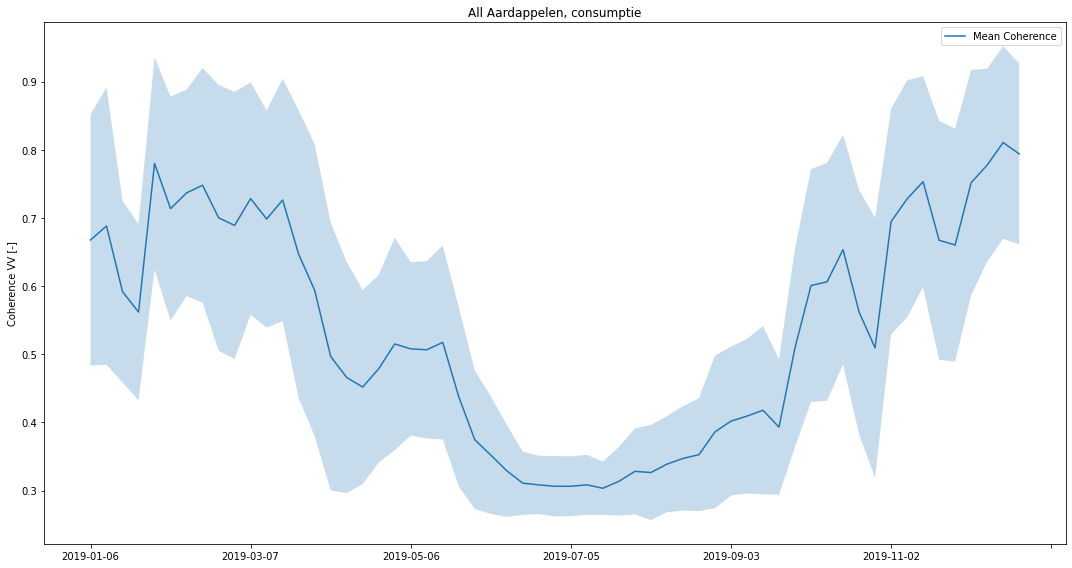

In [45]:
# 3) Plotting mean and variation for crop in province (Considering one Orbit)

# Function to calculate mean and std per field in a object ID selection

mean = df_crop.mean()
std = df_crop.std()

vv = [mean, std]



fig,ax= plt.subplots(figsize=(15,8))
var = vv
ax = var[0].plot(label = 'Mean Coherence')
ax.fill_between(var[0].index,  var[0] -  var[1],  var[0] +  var[1],
                alpha=.25)
ax.tick_params(axis='x', labelrotation=0 )
ax.set_ylabel('Coherence VV [-]')
plt.legend()
plt.title('All ' + crop_string)
plt.tight_layout()

# Plotting spatial plots for a specific time step

In the fields (shapefile) the geometries are available to plot the field outlines. Filling these fields with colormaps depending on certain variables gives a good illustration of the spatial value distribution for a certain time step. 

In [58]:
# Get date and create dateframe per time step for all fields

# Example time step
x = 15 # Select random time step
time_sel = dates88[x] # Select random date as an example 


geo_df = fields_sel # Create new dataframe 
coh_sel = []

for field in range(len(coh)):
    
    df_plot =coh.iloc[field,x]
    coh_sel.append(df_plot)
    
geo_df['coh'] = coh_sel
print(geo_df.head())

C:\Users\Manuel Huber\Anaconda3\envs\jupyter\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


    OBJECTID CAT_GEWASC GWS_GEWASC   GEOMETRIE_    GEOMETRIE1  \
0    1526148   Grasland        265  1362.792304  10739.457356   
8    1526156   Grasland        331   915.961468  19576.013299   
9    1526157   Grasland        331   892.061326   9355.477784   
10   1526158   Grasland        331  1242.573162  17196.435619   
11   1526159   Grasland        331  1862.054798  33129.177555   

                                       GWS_GEWAS  \
0                             Grasland, blijvend   
8   Grasland, natuurlijk. Hoofdfunctie landbouw.   
9   Grasland, natuurlijk. Hoofdfunctie landbouw.   
10  Grasland, natuurlijk. Hoofdfunctie landbouw.   
11  Grasland, natuurlijk. Hoofdfunctie landbouw.   

                                             geometry       coh  
0   POLYGON ((4.72403 51.93995, 4.72401 51.94003, ...  0.351865  
8   POLYGON ((4.68349 51.96389, 4.68345 51.96389, ...  0.587997  
9   POLYGON ((4.67911 51.96654, 4.67911 51.96654, ...  0.545225  
10  POLYGON ((4.77378 51.94518, 

Text(0.5, 1.0, '2019-04-06 00:00:00')

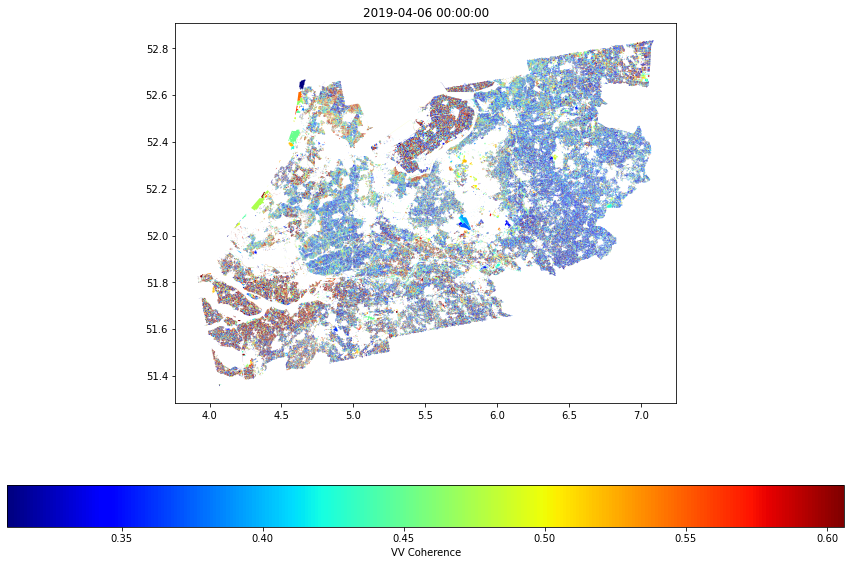

In [57]:
fig,ax= plt.subplots(figsize=(15,10))
gpd.GeoDataFrame(geo_df, geometry='geometry').plot(ax =ax,column = 'coh', cmap ='jet', legend=True, vmin =np.percentile(geo_df['coh'],10), vmax =np.percentile(geo_df['coh'],90),legend_kwds={'label': 'VV Coherence', 'orientation': "horizontal"})
plt.title(time_sel)